# Random Forest

Since Decision Trees have a tendency to overfit, Random Forests were introduced to reduce this risk by **building multiple decision trees and combining their outputs**. 

The key idea behind random forests is to use several trees, each of which might overfit on some part of the data but, by considering numerous instances we can reduce the level of overfit by averaging the results.

Image source: https://www.turing.com/kb/random-forest-algorithm


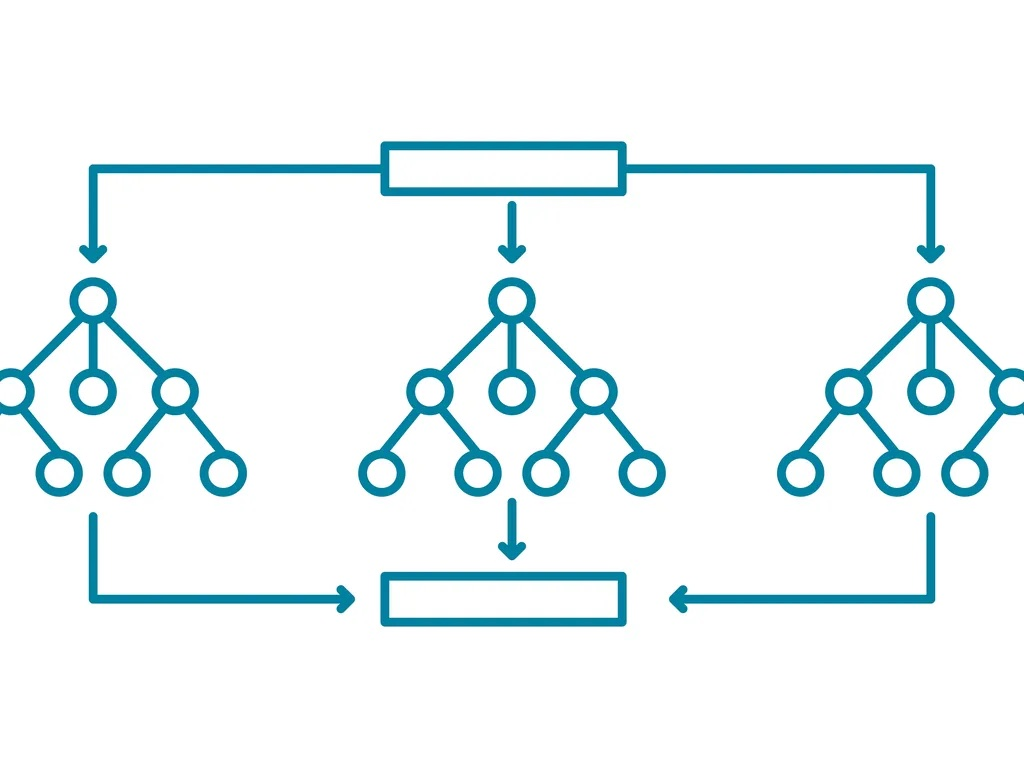

In [1]:
from IPython import display
print(f"Image source: https://www.turing.com/kb/random-forest-algorithm")
display.Image("images/Random_Forest.jpeg")

As the figure above shows, we have several trees built with the traning data and then we combine the results of the models to define an output that yields better predictions than any individual tree.

To introduce randomness in the tree growing process (and thus have different trees), 2 methods are regularly used: 
- **selecting random data points** (samples) and 
- **selecting random features** in which to split a node. 

There's also 2 common methods to combine trees (known as ensemble): **Bagging and Boosting**.

- **Bagging**:  Uses a random subset of the training data (sampled with replacement, meaning that the same data can be used more than once) and predictions (outputs) of individual resulting models are then aggregated (usually with an average for regression and a majority vote with classification). This method reduces the variance (sensitivity to noise) of the model. This is normally used in Random Forests.
- **Boosting**: Uses a single (normally 'shallow' -with few 'splits' or branches- or weak) model and **sequentially** builds additional models to 'correct' the erros made by previous trees. Each tree is trained on a different set of the training data, and more 'importante' (weight) is given to samples that were erroneously classified by previous trees (thus targeting the 'direction' of improvement). This type of models usually perform well on complex problems.

Image source: https://www.analyticsvidhya.com/blog/2021/06/understanding-random-forest/


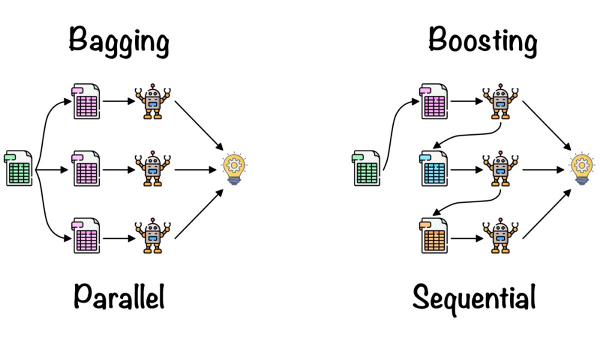

In [3]:
from IPython import display
print(f"Image source: https://www.analyticsvidhya.com/blog/2021/06/understanding-random-forest/")
display.Image("images/Bagging_Boosting.png")

The random sample selection usually considers **bootstrapping**, that is randomly selecting a part (usually 2/3) of the whole training data set with replacement. This way we can get many samples from the original training data set and create different trees (the training in fact stops when we reach the number of trees we want to create).

The random feature selection does not look for the best split for each node, but takes a **random subset of features** and looks for the best fit for one of these features. The number of feature to select is a key parameter. Usually, selecting a high number of features means that the trees to create will be rather similar to each other, while a low number of features will generate trees quite different between each other (and each tree will need a larger depth to fit the data).

To test Classification cases, the method considers using a 'vote' with the prediction of all the generated trees to define a final output (in regression cases, we normally use the average of the predictions).

## The code

In [4]:
import numpy as np
from collections import Counter

#Random forest class defines the number of trees to grow and compare 
#as well as the attributes a DecisionTreeClass has
class RandomForest:
    def __init__(self, n_trees = 10, min_samples_split = 2, max_depth = 50, n_features = None):
        self.n_trees = n_trees
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_features = n_features
        self.trees = [] #this will store the trees we grow as an array of trees
    
    #fit function for all the trees. We use the fit method from DecisionTreeClass to grow each tree
    def fit(self, X, y):
        self.trees = [] #initiate the trees array to empty
        #creates n_trees random trees 
        for _ in range(self.n_trees):
            tree = DecisionTreeClass(min_samples_split = self.min_samples_split, 
                                     max_depth = self.max_depth,
                                     n_features = self.n_features)
            X_sample, y_sample = self._bootstrap(X,y) #randomly select a sub-set of the training data with replacement
            tree.fit(X_sample, y_sample) #grow the tree with the subset of samples
            self.trees.append(tree) #we add the newly created tree to the trees array
    
    
    #randomly select 2/3 of the total training data for each random tree
    def _bootstrap(self, X, y):
        n_train_set = X.shape[0]
        samples_indx = np.random.choice(n_train_set, int(n_train_set * 2/3), replace = True)
        return X[samples_indx], y[samples_indx]
    
    #define prediction from a test sample. Notice that we use the predict method from DesicionTreeClass
    def predict(self, X_sample):
        """this returns an a set of 'n_trees' number of arrays, 
        each with the predictions for every test sample in X_sample"""
        predics = np.array([tree.predict(X_sample) for tree in self.trees])
        
        #with this function we create len(X_sample) number of arrays, 
        #each with the predictions for one value of X_sample so we can easily evaluate the most voted result 
        preds_by_tree = self.restruct_array(predics)
        
        #takes the most 'voted' prediction for each result and returns an array with it
        results_ = []
        for result in preds_by_tree:
            count = Counter(result)
            results_.append(count.most_common(1)[0][0])
            
        return results_
        
        #this function returns
    def restruct_array(self, arrays):
        n = len(arrays)
        m = len(arrays[0])  # Assuming all arrays have the same length

        result = [[] for _ in range(m)]

        for i in range(m):
            for j in range(n):
                result[i].append(arrays[j][i])
        return result

Notice that we'll also need the code for Decision Trees (though we could import it as a library)

In [5]:
import numpy as np
from collections import Counter

class Node():
    def __init__(self, index = None, threshold = None, left_branch = None, right_branch = None, info_gain = None, *, value = None):
        
        #decision nodes 
        self.feature_index = index
        self.threshold = threshold
        self.left = left_branch
        self.right = right_branch
        self.info_gain = info_gain
        self.value = value #Notice that value is only defined for leaf/terminal nodes 
        
    def is_leaf_node(self):
        return self.value is not None

class DecisionTreeClass():
    def __init__(self, min_samples_split = 2, max_depth = 50, n_features = None):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_features = n_features
        self.root = None

    def fit(self, X, y):
        #get characteristics of the [remaining] training data set (consider the min between the defined features and the given features)
        self.n_features = X.shape[1] if not self.n_features else min(X.shape[1], self.n_features)
        self.root = self._grow_tree(X,y)
        
    #this is the key method. It recursively create tree (with initial depth = 0)
    def _grow_tree(self, X, y, depth = 0):
        n_samples = X.shape[0]
        n_rem_labels = len(np.unique(y)) #records the different labels for the remaining samples in the training set
        
        #check stopping criteria: size of tree, only 1 label (entropy = 0)
        if (depth >= self.max_depth or n_rem_labels == 1 or n_samples <= self.min_samples_split):
            counter = Counter(y)
            leaf_value = counter.most_common(1)[0][0] #this is the label of the most common element in this terminal node
            return Node(value = leaf_value)
        
        #find the best split for the node
        #1st we randomly select the features. Notice that we can also select just a portion of the feature, not nec. all of them
        feat_indexes = np.random.choice(range(self.n_features), self.n_features, replace = False) 
        best_feat, best_thrsh  = self._best_split(X, y, feat_indexes)
        
        #create children nodes recursively slicing the sample
        left_indexes, right_indexes = self._split(X[:, best_feat], best_thrsh)
        left = self._grow_tree(X[left_indexes], y[left_indexes], depth + 1)
        right = self._grow_tree(X[right_indexes], y[right_indexes], depth + 1)
        
        return Node(best_feat, best_thrsh, left, right)
        
        
    #this function evaluates all possible splits and defines the one 
    #that maximises the information gain
    def _best_split(self, X, y, feat_indexes):
        best_gain = -10
        split_index, split_thrshld = None, None
        
        #we define all possible splits
        for f_indx in feat_indexes:
            X_col = X[:, f_indx]
            thrshld = np.unique(X_col)
            
            for thr in thrshld:
                inf_gain = self._inf_gain(y, X_col,thr)
                
                #update the register for the best gain split
                if inf_gain > best_gain:
                    best_gain = inf_gain 
                    split_index = f_indx
                    split_thrshld = thr
        
        return split_index, split_thrshld
        
    #calculates and returns information gain for a given threshold to split on a node
    def _inf_gain(self, y, X_col, thr):
        #parent's entropy
        parent_entropy = self._entropy(y)
        
        #define children's branches by indixes
        left_branch, right_branch = self._split(X_col, thr)
        
        #if there's no more splitting to do, inf. gain is null
        if len(left_branch) == 0 or len(right_branch) == 0:
            return 0
        
        #define children's entropy
        n_left, n_right = len(left_branch), len(right_branch)
        entropy_left, entropy_right = self._entropy(y[left_branch]), self._entropy(y[right_branch])
        children_entropy = (n_left/len(y))*entropy_left + (n_right/len(y))*entropy_right
        
        #calculate information gain
        inf_gain = parent_entropy - children_entropy
        return inf_gain
        
    #returns arrays with left-right branches according to a threshold value
    def _split(self, X_col, split_thr):
        left_child = np.argwhere(X_col <= split_thr).flatten() #we use flatten() to have just one array
        right_child = np.argwhere(X_col > split_thr).flatten() #we use flatten() to have just one array
        return left_child, right_child
    
    #calculate entropy for a given sample set of labels
    def _entropy(self, y):
        labels, labels_count = np.unique(y, return_counts = True)
        prop_label = labels_count / len(y)
        return -np.sum([p*np.log(p) for p in prop_label if p > 0])
    
    #return an array of the predictions for an array of values    
    def predict(self, X):
        return np.array([self._gothrough_tree(x, self.root) for x in X])
        

    #recursively determine the end_node for a given value and return its most prominent label(prediction)
    def _gothrough_tree(self, x, node):

        #for terminal node, return its value
        if node.is_leaf_node():
            return node.value
        
        if x[node.feature_index] <= node.threshold:
            return self._gothrough_tree(x, node.left)
        return self._gothrough_tree(x, node.right)

Now, let's load the data and separate it into training and test sets:

In [6]:
#importing a data set
import numpy as np
import pandas as pd

col_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'type']
data = pd.read_csv("data/Iris.csv", skiprows = 1, header = None, names = col_names)
data.head(10)

data.shape

X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values#.reshape(-1,1)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=41)

And now, will fit the model with the training set:

In [16]:
import time

time_ini_self_coding = time.time()
rf = RandomForest(n_trees = 30)
rf.fit(X_train, y_train)
time_end_self_coding = time.time()

time_self_code = time_end_self_coding - time_ini_self_coding

Again, let's compare with the **random classifier from Sklearn**. We will consider the same parameters as our own model, that's 30 random trees (n_estimators), a maximum depth (splits) of 50 per tree and a minimum of samples to stop splitting of 2. The calculation is based on Entropy instead of Gini.

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
import time

time_ini_sklearn = time.time()
clf = RandomForestClassifier(n_estimators = 30, criterion='entropy', max_depth=50, min_samples_split=2)
clf.fit(X_train, y_train)
time_end_sklearn = time.time()

time_sklearn = time_end_sklearn - time_ini_sklearn

Let's make the predictions with both models:

In [18]:
# Self coded model
predictions_self_code = rf.predict(X_test)
predictions_sklearn = clf.predict(X_test)

In [19]:
#evaluate accuracy
def accuracy(y_test, y_prediction):
    return np.sum(y_test == y_prediction) / len(y_test)

Now, let's try the sklearn Random Forest Classifier to compare results.

In [20]:
acc_self_code = accuracy(y_test, predictions_self_code)
acc_sklearn = accuracy(y_test, predictions_sklearn)

print(f"Accuracy for self code: {acc_self_code:.4f}\nTime to fit: {time_self_code:.6f}")
print("\n")
print(f"Accuracy for sklearn: {acc_sklearn:.4f}\nTime to fit: {time_sklearn:.6f}")


# increased/decreased efficiency with sklearn:
print(f"Sklearn is {(time_self_code/time_sklearn):.0f} times faster than the python code")

Accuracy for self code: 0.7667
Time to fit: 0.913347


Accuracy for sklearn: 0.9000
Time to fit: 0.034631
Sklearn is 26 times faster than the python code


Again sklearn is more accurate and several times faster considering the same parameters. 